## Basic Caption Cookbook
This notebook demonstrates how to use the captioning API to generate captions for images with guided outputs.

Grounding is very basic right now and just includes a simple chain of thought with generated tags using default sampling. A future PR will focus on honing in on optimizing the sampling params to further reduce visual hallucinations. 

In [7]:
import os
import httpx
from typing import Union
from PIL import Image
import io

client = httpx.Client(timeout=60.0)
from PIL import Image, ImageDraw, ImageFont
from odr_caption.outlines.vision import load_image, load_img_from_url


def generate_caption(image_path: Union[str, os.PathLike]):
    # Load and resize image
    if image_path.startswith(('http://', 'https://')):
        response = httpx.get(image_path)
        image = Image.open(io.BytesIO(response.content))
    else:
        image = Image.open(image_path)
    
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    files = {"file": ("image.png", img_byte_arr, "image/png")}
    response = client.post("http://localhost:32100/generate_caption", files=files)
    
    if response.status_code == 200:
        caption_data = response.json()["content"]
    else:
        raise Exception(f"Error: {response.status_code}, {response.text}")
    
    generate_report(image, caption_data)
    
    return caption_data

"""Report gen stuff for this notebook, not needed for captioning"""
def generate_report(image, caption_data):
    # resize for notebook display
    max_size = 512
    ratio = max_size / max(image.size)
    new_size = tuple([int(x*ratio) for x in image.size])
    image = image.resize(new_size, Image.LANCZOS)
    
    # Determine report dimensions
    image_width, image_height = image.size
    text_width = 500  # Approximate width needed for text
    report_width = min(1024, image_width + text_width + 20)  # Add some padding
    report_height = max(512, image_height)
    
    # Create the report image
    report = Image.new('RGB', (report_width, report_height), color='white')
    
    # Paste the resized image
    report.paste(image, (0, 0))
    
    # Add caption information
    draw = ImageDraw.Draw(report)
    title_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 14)
    body_font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 12)
    
    text_start_x = image_width + 10  # Start text right after the image
    text_start_y = 10
    line_height = 18
    
    # Short Caption
    draw.text((text_start_x, text_start_y), "Short Caption:", fill='black', font=title_font)
    draw.text((text_start_x, text_start_y + line_height), caption_data['short_caption'], fill='black', font=body_font)
    
    # Dense Caption
    draw.text((text_start_x, text_start_y + 3*line_height), "Dense Caption:", fill='black', font=title_font)
    wrapped_dense_caption = wrap_text(caption_data['dense_caption'], body_font, report_width - text_start_x - 10)
    for i, line in enumerate(wrapped_dense_caption):
        draw.text((text_start_x, text_start_y + (4+i)*line_height), line, fill='black', font=body_font)
    
    # Tags
    draw.text((text_start_x, text_start_y + 13*line_height), "Tags:", fill='black', font=title_font)
    for i, tag in enumerate(caption_data['tags_list']):
        tag_text = f"{tag['tag']} ({tag['category']}, {tag['confidence']:.2f})"
        draw.text((text_start_x, text_start_y + (14+i)*line_height), tag_text, fill='black', font=body_font)
    
    # Display the report
    display(report)

def wrap_text(text, font, max_width):
    words = text.split()
    lines = []
    current_line = []
    for word in words:
        test_line = ' '.join(current_line + [word])
        bbox = font.getbbox(test_line)
        if bbox[2] <= max_width:
            current_line.append(word)
        else:
            lines.append(' '.join(current_line))
            current_line = [word]
    lines.append(' '.join(current_line))
    return lines




## Examples


URL image report:


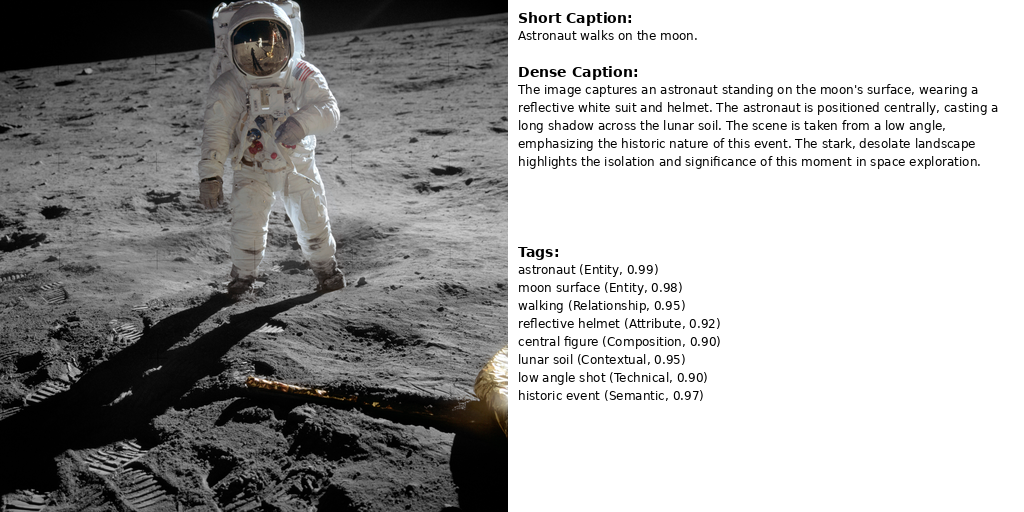

{'tags_list': [{'tag': 'astronaut', 'category': 'Entity', 'confidence': 0.99},
  {'tag': 'moon surface', 'category': 'Entity', 'confidence': 0.98},
  {'tag': 'walking', 'category': 'Relationship', 'confidence': 0.95},
  {'tag': 'reflective helmet', 'category': 'Attribute', 'confidence': 0.92},
  {'tag': 'central figure', 'category': 'Composition', 'confidence': 0.9},
  {'tag': 'lunar soil', 'category': 'Contextual', 'confidence': 0.95},
  {'tag': 'low angle shot', 'category': 'Technical', 'confidence': 0.9},
  {'tag': 'historic event', 'category': 'Semantic', 'confidence': 0.97}],
 'short_caption': 'Astronaut walks on the moon.',
 'verification': 'The tags match the visual content accurately, depicting an astronaut on the moon walking.',
 'dense_caption': "The image captures an astronaut standing on the moon's surface, wearing a reflective white suit and helmet. The astronaut is positioned centrally, casting a long shadow across the lunar soil. The scene is taken from a low angle, emph

In [8]:
url_image_path = "https://upload.wikimedia.org/wikipedia/commons/9/98/Aldrin_Apollo_11_original.jpg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)

In [41]:
# We can also read in the object into the Schema for ease of use further in the pipeline if needed 
from odr_caption.schemas.caption import ImageData
image_data = ImageData(**caption_data)
print("Dense Caption: ", image_data.dense_caption)
print("Short Caption: ", image_data.short_caption)
print("Tags: ")
for tag in image_data.tags_list:
      print(tag)



Dense Caption:  The image depicts an astronaut standing upright on the moon's surface, clad in a pristine white spacesuit. The lunar landscape is marked with the tracks of the lunar module, indicating human activity. The astronaut's helmet reflects the stark surroundings, emphasizing the isolation and vastness of the lunar environment. The low angle shot captures the grandeur of the moment, highlighting humanity's monumental achievement in space exploration.
Short Caption:  Astronaut walks on the moon surface.
Tags: 
tag='astronaut' category=<TagType.ENTITY: 'Entity'> confidence=0.99
tag='moon surface' category=<TagType.ENTITY: 'Entity'> confidence=0.97
tag='walking' category=<TagType.RELATIONSHIP: 'Relationship'> confidence=0.95
tag='white spacesuit' category=<TagType.ATTRIBUTE: 'Attribute'> confidence=0.99
tag='upright stance' category=<TagType.ATTRIBUTE: 'Attribute'> confidence=0.98
tag='lunar module tracks' category=<TagType.CONTEXTUAL: 'Contextual'> confidence=0.9
tag='low angle s

## Additional Examples


URL image report:


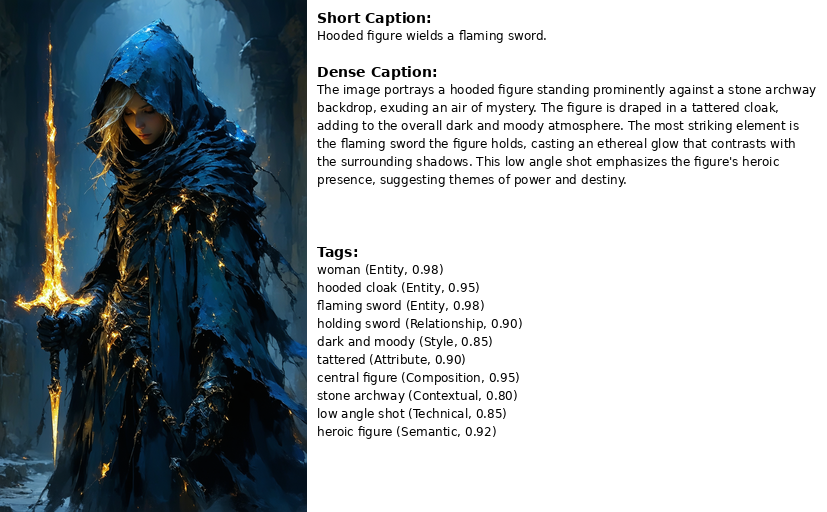

{'tags_list': [{'tag': 'woman', 'category': 'Entity', 'confidence': 0.98},
  {'tag': 'hooded cloak', 'category': 'Entity', 'confidence': 0.95},
  {'tag': 'flaming sword', 'category': 'Entity', 'confidence': 0.98},
  {'tag': 'holding sword', 'category': 'Relationship', 'confidence': 0.9},
  {'tag': 'dark and moody', 'category': 'Style', 'confidence': 0.85},
  {'tag': 'tattered', 'category': 'Attribute', 'confidence': 0.9},
  {'tag': 'central figure', 'category': 'Composition', 'confidence': 0.95},
  {'tag': 'stone archway', 'category': 'Contextual', 'confidence': 0.8},
  {'tag': 'low angle shot', 'category': 'Technical', 'confidence': 0.85},
  {'tag': 'heroic figure', 'category': 'Semantic', 'confidence': 0.92}],
 'short_caption': 'Hooded figure wields a flaming sword.',
 'verification': 'The image clearly depicts a hooded figure holding a flaming sword, which matches the tags provided.',
 'dense_caption': "The image portrays a hooded figure standing prominently against a stone archway 

In [42]:
url_image_path = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/00300e2b-bc02-4e26-96ac-506b4bce95ea/original=true,quality=90/35990960.jpeg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)


URL image report:


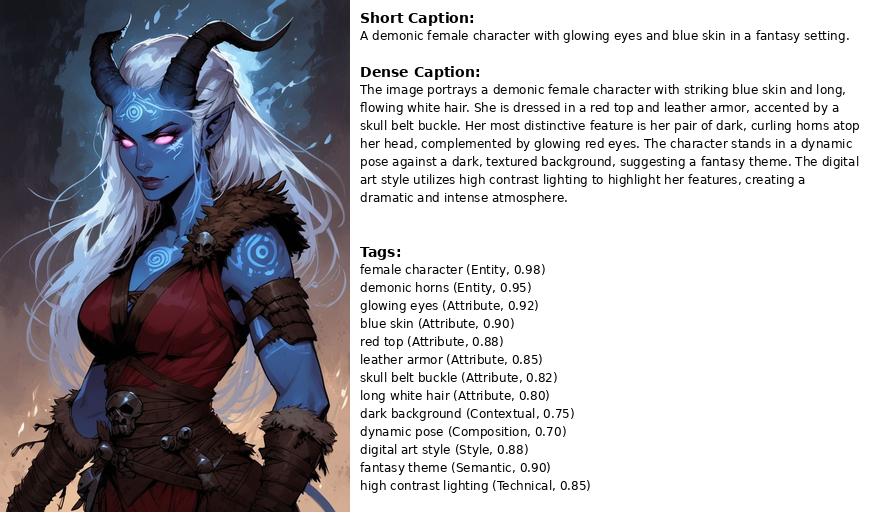

{'tags_list': [{'tag': 'female character',
   'category': 'Entity',
   'confidence': 0.98},
  {'tag': 'demonic horns', 'category': 'Entity', 'confidence': 0.95},
  {'tag': 'glowing eyes', 'category': 'Attribute', 'confidence': 0.92},
  {'tag': 'blue skin', 'category': 'Attribute', 'confidence': 0.9},
  {'tag': 'red top', 'category': 'Attribute', 'confidence': 0.88},
  {'tag': 'leather armor', 'category': 'Attribute', 'confidence': 0.85},
  {'tag': 'skull belt buckle', 'category': 'Attribute', 'confidence': 0.82},
  {'tag': 'long white hair', 'category': 'Attribute', 'confidence': 0.8},
  {'tag': 'dark background', 'category': 'Contextual', 'confidence': 0.75},
  {'tag': 'dynamic pose', 'category': 'Composition', 'confidence': 0.7},
  {'tag': 'digital art style', 'category': 'Style', 'confidence': 0.88},
  {'tag': 'fantasy theme', 'category': 'Semantic', 'confidence': 0.9},
  {'tag': 'high contrast lighting',
   'category': 'Technical',
   'confidence': 0.85}],
 'short_caption': 'A demo

In [43]:
url_image_path = "https://image.civitai.com/xG1nkqKTMzGDvpLrqFT7WA/81f8e626-a822-4815-b8be-361ff65b0d88/original=true,quality=90/16382509.jpeg"
print("\nURL image report:")
caption_data = generate_caption(url_image_path)
display(caption_data)